# Descrição do Trabalho
O arquivo trabalho.zip possui imagens de leucócitos na parte central. As imagens são nomeadas como "ImXXX_Y_Z.jpg". Onde ImXXX é o número da imagem, Y é o seu número da sequência de alteração (data augmentation) e Z a sua classe (0 ou 1). Onde, 0 indica paciente normal e 1 pacientes com leucemia.

Utilizando técnicas de Visão Computacional e/ou CNNS extraia características das imagens e faça a sua correta classificação (0 ou 1). Lembre-se de separar os grupos de treinamento e teste. Você pode utilizar a técnica de k-folds para a divisão das imagens e evitar o overfitting.

Entregue um arquivo zip com um relatório do seu trabalho, o(s) código(s) fonte(s) e um README indicando como o seu trabalho funciona. Você pode fazer no Colab e disponibilizar o arquivo fonte.

In [1]:
from IPython.display import Image 
import numpy as np

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam


import keras
import os

In [2]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

import keras as K
print("Versão do Keras:", K.__version__)

Versão do TensorFlow: 2.4.0
Versão do Keras: 2.4.3


#### Executar o comando abaixo somente se estiver rodando no Colab

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#images_root_path = '/content/drive/MyDrive/IAP/VISAO COMPUTACIONAL/output/'
import pathlib
current_path = str(pathlib.Path().absolute())
images_root_path = current_path + '\\data\\'
train_path = images_root_path + 'train_data'
test_path = images_root_path + 'test_data'
validation_path = images_root_path + 'val_data'

In [7]:
images_root_path

'x:\\Git\\cnn-leucemia\\data\\'

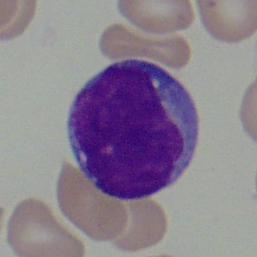

In [8]:
Image(filename=f'{train_path}\\class_b\\Im001_0_1.jpg')

## Pré-Processamento

In [9]:
# Train dataset
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

training_set = train_datagen.flow_from_directory(
    train_path,
    seed=42,
    target_size = (256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

# Validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    validation_path,
    seed=42,
    target_size = (256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Found 3820 images belonging to 2 classes.
Found 546 images belonging to 2 classes.


## Modelo

* métrica escolida foi RECALL para evitar o **FALSO NEGATIVO** 

In [10]:
tf.keras.backend.clear_session()

# Inicializando a Rede Neural Convolucional
classifier = Sequential()

# Camada de Convolução
classifier.add(layers.Conv2D(
    filters=64, 
    kernel_size=(6, 6), 
    input_shape=(256,256,3), 
    activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size=(2, 2)))

classifier.add(layers.Conv2D(
    filters=64, 
    kernel_size=(3, 3), 
    kernel_initializer = 'he_uniform', 
    activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size=(2, 2)))

classifier.add(layers.Conv2D(
    filters=128,
    kernel_size=(2, 2),
    strides=(1,1), 
    kernel_initializer = 'he_uniform', 
    activation='relu'))

classifier.add(layers.Flatten())

classifier.add(layers.Dense(512, activation='relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(512, activation='relu'))
classifier.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compilando a rede
classifier.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'binary_crossentropy', 
    metrics = [
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy')])

In [11]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 251, 251, 64)      6976      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 123, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       1

## Treinamento

In [12]:
# Executando o treinamento (esse processo pode levar bastante tempo, dependendo do seu computador)
history = classifier.fit(
    training_set,
    steps_per_epoch = 100,
    epochs = 5,
    validation_data = validation_set,
    validation_steps = 10)

classifier.save('model')

Epoch 1/5
100/100 [==============================] - 388s 4s/step - loss: 0.9676 - fn: 333.2178 - accuracy: 0.5492 - val_loss: 0.5772 - val_fn: 1.0000 - val_accuracy: 0.7563
Epoch 2/5
100/100 [==============================] - 397s 4s/step - loss: 0.5471 - fn: 154.0693 - accuracy: 0.7149 - val_loss: 0.4679 - val_fn: 21.0000 - val_accuracy: 0.7906
Epoch 3/5
100/100 [==============================] - 432s 4s/step - loss: 0.5063 - fn: 125.4950 - accuracy: 0.7532 - val_loss: 0.4234 - val_fn: 15.0000 - val_accuracy: 0.8000
Epoch 4/5
100/100 [==============================] - 427s 4s/step - loss: 0.4540 - fn: 111.9010 - accuracy: 0.7803 - val_loss: 0.3847 - val_fn: 4.0000 - val_accuracy: 0.8438
Epoch 5/5
100/100 [==============================] - 429s 4s/step - loss: 0.4504 - fn: 124.9109 - accuracy: 0.7757 - val_loss: 0.3411 - val_fn: 14.0000 - val_accuracy: 0.8281
INFO:tensorflow:Assets written to: model\assets


In [13]:
# Zip saved model
# !zip -r ./model.zip ./model/

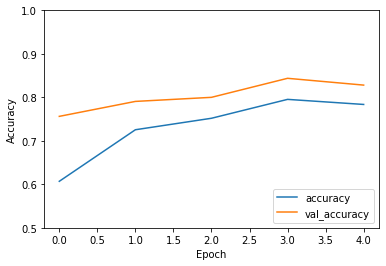

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Previsões

In [15]:
# LOAD MODEL FROM GDRIVE
#classifier = tf.keras.models.load_model('/content/drive/MyDrive/IAP/VISAO COMPUTACIONAL/model')
#classifier.summary()

In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)

testing_set = test_datagen.flow_from_directory(
    test_path,
    seed=42,
    target_size = (256, 256),
    batch_size = 110,
    class_mode = 'binary')

num_of_samples = len(testing_set.filenames)

Found 1094 images belonging to 2 classes.


In [28]:
classifier.evaluate(testing_set, batch_size=10)

10/10 [==============================] - 35s 3s/step - loss: 0.2509 - fn: 30.0000 - accuracy: 0.8793


[0.2508886158466339, 30.0, 0.8793418407440186]

In [29]:
# Predicoes na base de teste
#predicted = classifier.predict(testing_set)
predicted = (classifier.predict(testing_set) > 0.5).astype("int32")
predicted = [pred[0] for pred in predicted]
#predicted=np.argmax(predicted,axis=1)

In [30]:
confusion_matrix(testing_set.classes, predicted)

array([[249, 298],
       [226, 321]], dtype=int64)

In [31]:
accuracy_score(testing_set.classes, predicted)

0.5210237659963437

In [32]:
fpr, tpr, _ = roc_curve(testing_set.classes, predicted)
roc_auc = auc(fpr, tpr)
print(roc_auc) # 0.48687706586366053

0.5210237659963437


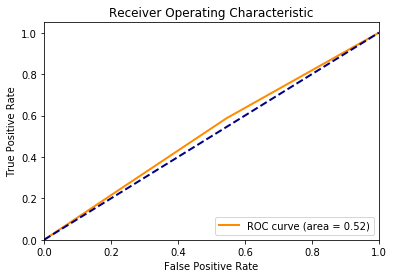

In [33]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()